In [2]:
from gen_recover import *
import matplotlib.pyplot as plt
import math
%matplotlib inline
import numpy as np
import scipy

# Distributions

Define distributions here (Truncated Gaussian, discrete, etc.) 

In [3]:
def silly_3():
    return 1 / 4.0 + float(int(random.random() * 3)) / 4.0

In [4]:
def normal(m, s):
    r = np.random.normal(loc=m, scale=s)
    if r < 0.0 or r > 1.0:
        return normal(m, s)
    return r

In [5]:
def normal_fixedp():
    return normal(0.5, 0.15)

In [6]:
def uniform():
    return random.random()

# Interpolation

Experiment with interpolation method here

In [7]:
# normalized objectives by empirical stdevs
def experiment_histog(moments, stdevs, m):
    k = len(moments)
    from cvxopt import matrix, solvers
    solvers.options['show_progress'] = False
    A = np.zeros((m + 2 * k + 3, m + k + 1))
    B = np.zeros(m + 2 * k + 3)
    C = np.zeros(m + k + 1)
    # set C (optimization)
    for i in xrange(m + 1, m + k + 1):
        C[i] = 1.0
    # set B (constraints)
    B[0] = 1.0
    B[1] = -1.0
    for i in xrange(k):
        B[m + 3 + (2 * i)] = moments[i]
        B[m + 3 + (2 * i) + 1] = -1.0 * moments[i]
    # set A (linear coefficients)
    for i in xrange(m + 1):
        A[0][i] = 1.0
        A[1][i] = -1.0
        A[2 + i][i] = -1.0

    for j in xrange(k):
        A[m + 3 + (2 * j)][m + 1 + j] = -1.0
        A[m + 3 + (2 * j) + 1][m + 1 + j] = -1.0
        for i in xrange(m + 1):
            A[m + 3 + (2 * j)][i] = (((float(i) / float(m))) ** (j + 1))
            A[m + 3 + (2 * j) + 1][i] = (-1.0 * ((float(i) / float(m))) ** (j + 1))
    # print A
    G = matrix(np.ndarray.tolist(np.transpose(A)))
    h = matrix(np.ndarray.tolist(B))
    weights = np.zeros(m + k + 1)
    for i in xrange(k):
        weights[m + i + 1] = 1.0 / (stdevs[i] ** 2)
    P = matrix(np.ndarray.tolist(np.diag(weights)))
    q = matrix(np.ndarray.tolist(np.zeros(m + k + 1)))
    # print B
    # print C
    #sol = solvers.lp(matrix(np.ndarray.tolist(C)), matrix(np.ndarray.tolist(A)), matrix(np.ndarray.tolist(B)))
    sol = solvers.qp(P, q, G, h)
    #print np.dot(C, np.asarray(sol['x']))
    return sol['x']

In [8]:
def stdevs(mesh, weights, n):
    # compute true variances of our estimated distribution for first n moments
    stdevs = []
    for k in xrange(1, n + 1):
        # compute expectation
        mean = sum([weights[i] * (mesh[i] ** k) for i in xrange(len(mesh))])
        variance = sum([max(0, weights[i]) * (((mesh[i] ** k) - mean) ** 2) for i in xrange(len(mesh))])
        stdevs.append(math.sqrt(variance))
    return stdevs

# Conversion tools

In [16]:
def cdf(mesh):
    return np.cumsum(mesh)

def cdf_distro(sample_ps, granularity):
    ss = sorted(sample_ps)
    cdf = np.zeros(granularity + 1)
    for p in ss:
        cdf[int(p * granularity) + 1 : granularity + 1] += np.ones(granularity - int(p * granularity))
    cdf /= float(len(ss))
    return cdf

def cdf_dist(c0, c1):
    return np.sum(np.absolute(c0 - c1)) / float(len(c0) - 1)

# Gender ratio test

In [9]:
offspring = np.genfromtxt('export_120417.csv', delimiter=',', skip_header=1)

In [10]:
sires = {}
for statistic in offspring:
    if statistic[2] + statistic[3] == statistic[1]:
        if statistic[4] in sires:
            sires[statistic[4]].append([statistic[1], statistic[2], statistic[3]])
        else:
            sires[statistic[4]] = [[statistic[1], statistic[2], statistic[3]]]

In [11]:
collapsed_sires = {}

# collapse same sire
for sire in sires:
    aggregate = np.asarray([0.0, 0.0, 0.0])
    for statistic in sires[sire]:
        aggregate += np.asarray(statistic)
    collapsed_sires[sire] = aggregate

In [12]:
separated_sires = []

for sire in sires:
    for statistic in sires[sire]:
        separated_sires.append(statistic)

In [13]:
moments = []
for m in xrange(1, 16):
    count = 0.0
    running_sum = 0.0
    for sire in separated_sires:
        offspring, boys = sire[0], sire[1]
        if offspring >= m:
            count += 1.0
            running_sum += float(comb(boys, m)) / float(comb(offspring, m))
    print m, count
    moments.append(running_sum / count)

1 7948.0
2 7417.0
3 6667.0
4 5562.0
5 4312.0
6 3075.0
7 2061.0
8 1244.0
9 694.0
10 339.0
11 154.0
12 58.0
13 21.0
14 8.0
15 2.0


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0408e-16  2e+03  3e+01  2e+01  1e+00
 1: -7.7738e-01 -2.0653e-01  1e+02  4e+00  3e+00  7e-01
 2: -1.4231e-01 -1.6243e-01  1e+01  7e-01  5e-01  4e-03
 3: -8.8577e-02 -9.9282e-02  4e+00  4e-01  3e-01  5e-03
 4: -1.4837e-02 -1.3030e-02  3e-01  1e-01  7e-02  6e-03
 5: -1.5210e-03 -1.0083e-03  5e-02  3e-02  2e-02  2e-03
 6:  3.3791e-03  3.4832e-03  7e-03  5e-03  4e-03  3e-04
 7:  3.1456e-03  3.1882e-03  6e-03  5e-03  3e-03  2e-04
 8:  3.4567e-03  3.4570e-03  1e-03  1e-03  7e-04  4e-05
 9:  3.5611e-03  3.5552e-03  5e-04  5e-04  3e-04  1e-05
10:  3.6224e-03  3.6187e-03  9e-04  4e-04  3e-04  1e-05
11:  3.6320e-03  3.6270e-03  1e-03  4e-04  3e-04  1e-05
12:  3.6651e-03  3.6550e-03  6e-04  3e-04  2e-04  8e-07
13:  3.7325e-03  3.7282e-03  3e-04  1e-04  8e-05  2e-07
14:  3.7319e-03  3.7286e-03  2e-04  1e-04  6e-05  2e-07
15:  3.7417e-03  3.7407e-03  6e-05  3e-05  2e-05  4e-08
16:  3.7444e-03  3.7442e-03  1e-05  6e-06  4e-06  

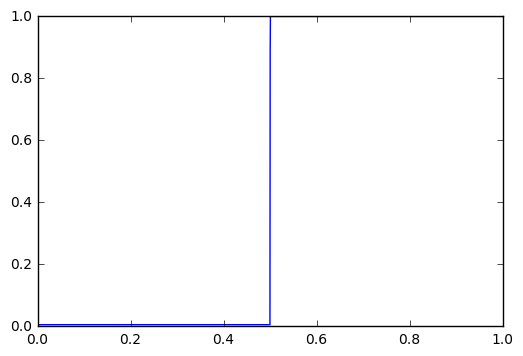

In [17]:
total_cdf = interpolate_histog(moments[:6], 2000)[:2001]
x_mesh = np.linspace(0, 1, 2001)
y_mesh = cdf(total_cdf)
axes = plt.gca()
axes.set_ylim([0.0, 1.0])
plt.plot(x_mesh, y_mesh)

# Bootstrap estimates

Estimates for variance of moments

In [18]:
def moments_stdevs(samples, k):
    n, s = samples.shape
    counts = np.sum(samples, axis=1)
    mom_dist = [np.asarray([float(comb(counts[j], i)) / float(comb(s, i)) for j in xrange(n)]) for i in xrange(1, k + 1)]
    moments = [np.mean(mom) for mom in mom_dist]
    stdevs = [np.std(mom) / math.sqrt(n) for mom in mom_dist]
    return moments, stdevs

In [19]:
def moments_stdevs_stacked(samples, k):
    moments = []
    stdevs = []
    for i in xrange(1, k + 1):
        mom_dist = np.asarray([float(comb(row[1], i)) / float(comb(row[0], i)) for row in samples if (row[0] >= i)])
        moments.append(np.mean(mom_dist))
        stdevs.append(np.std(mom_dist) / math.sqrt(len(mom_dist)))
    return moments, stdevs

# Experiment

Test how good the interpolation method performs

0.0195551264685 0.0624940345078 0.0787085


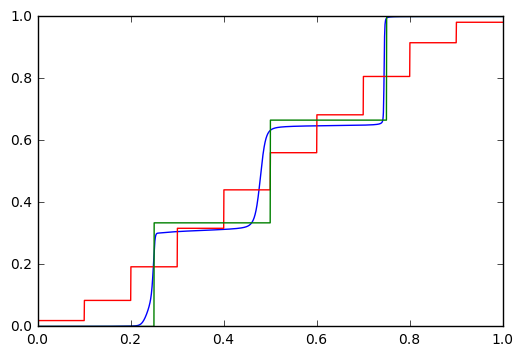

In [24]:
# TEST QP

sample_ps = [silly_3() for i in xrange(100000)]
r = 10
samples = gen(sample_ps, r)
n = len(samples)
m, s = moments_stdevs(samples, r)
#for i in xrange(r):
#    s[i] = float(i) / math.sqrt(m[i])
m_h, s_h = m[: r/2], s[: r/2]
total_cdf = experiment_histog(m, s, 2000)[:2001]
total_cdf_h = experiment_histog(m_h, s_h, 2000)[:2001]
empirical_ps = np.asarray([(float(sum(row)) / float(len(row))) for row in samples])
x_mesh = np.linspace(0, 1, 2001)
y_mesh = cdf(total_cdf)
y_mesh_h = cdf(total_cdf_h)
axes = plt.gca()
axes.set_ylim([0.0, 1.0])
plt.plot(x_mesh, y_mesh, color="blue")
#plt.plot(x_mesh, y_mesh_h, color="green")
plt.plot(x_mesh, cdf_distro(empirical_ps, 2000), color="red")
plt.plot(x_mesh, cdf_distro(sample_ps, 2000), color="green")
print cdf_dist(y_mesh, cdf_distro(sample_ps, 2000)), 
print cdf_dist(y_mesh_h, cdf_distro(sample_ps, 2000)),
print cdf_dist(cdf_distro(empirical_ps, 2000), cdf_distro(sample_ps, 2000))    

0.00863804335642 0.00490695913025 0.056470315


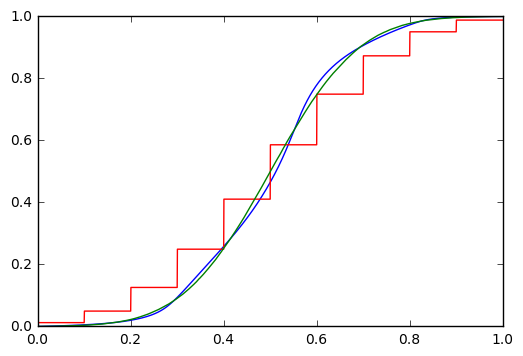

In [21]:
# TEST QP

sample_ps = [normal_fixedp() for i in xrange(100000)]
r = 10
samples = gen(sample_ps, r)
n = len(samples)
m, s = moments_stdevs(samples, r)
#for i in xrange(r):
#    s[i] = float(i) / math.sqrt(m[i])
m_h, s_h = m[: r/2], s[: r/2]
total_cdf = experiment_histog(m, s, 2000)[:2001]
total_cdf_h = experiment_histog(m_h, s_h, 2000)[:2001]
empirical_ps = np.asarray([(float(sum(row)) / float(len(row))) for row in samples])
x_mesh = np.linspace(0, 1, 2001)
y_mesh = cdf(total_cdf)
y_mesh_h = cdf(total_cdf_h)
axes = plt.gca()
axes.set_ylim([0.0, 1.0])
plt.plot(x_mesh, y_mesh, color="blue")
#plt.plot(x_mesh, y_mesh_h, color="green")
plt.plot(x_mesh, cdf_distro(empirical_ps, 2000), color="red")
plt.plot(x_mesh, cdf_distro(sample_ps, 2000), color="green")
print cdf_dist(y_mesh, cdf_distro(sample_ps, 2000)), 
print cdf_dist(y_mesh_h, cdf_distro(sample_ps, 2000)),
print cdf_dist(cdf_distro(empirical_ps, 2000), cdf_distro(sample_ps, 2000))

0.00403451702892 0.000885845596034 0.03186201


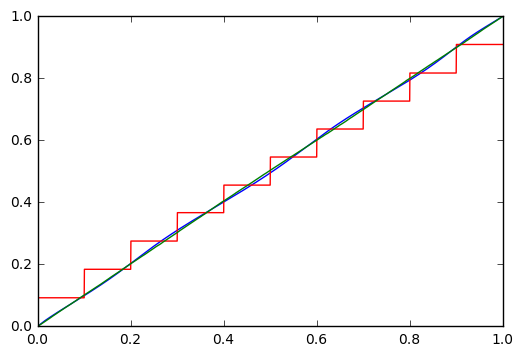

In [22]:
# TEST QP

sample_ps = [uniform() for i in xrange(100000)]
r = 10
samples = gen(sample_ps, r)
n = len(samples)
m, s = moments_stdevs(samples, r)
#for i in xrange(r):
#    s[i] = float(i) / math.sqrt(m[i])
m_h, s_h = m[: r/2], s[: r/2]
total_cdf = experiment_histog(m, s, 2000)[:2001]
total_cdf_h = experiment_histog(m_h, s_h, 2000)[:2001]
empirical_ps = np.asarray([(float(sum(row)) / float(len(row))) for row in samples])
x_mesh = np.linspace(0, 1, 2001)
y_mesh = cdf(total_cdf)
y_mesh_h = cdf(total_cdf_h)
axes = plt.gca()
axes.set_ylim([0.0, 1.0])
plt.plot(x_mesh, y_mesh, color="blue")
#plt.plot(x_mesh, y_mesh_h, color="green")
plt.plot(x_mesh, cdf_distro(empirical_ps, 2000), color="red")
plt.plot(x_mesh, cdf_distro(sample_ps, 2000), color="green")
print cdf_dist(y_mesh, cdf_distro(sample_ps, 2000)), 
print cdf_dist(y_mesh_h, cdf_distro(sample_ps, 2000)),
print cdf_dist(cdf_distro(empirical_ps, 2000), cdf_distro(sample_ps, 2000))    

In [42]:
# Code for experiment displayed in Fig. 1 of paper
normal_100k = np.zeros(14)
normal_10k = np.zeros(14)
normal_emp = np.zeros(14)

sample_ps = [normal_fixedp() for i in xrange(100000)]
smaller_sample_ps = sample_ps[:10000]
for j in xrange(30):
    print "RUN" + str(j)
    run_normal_100k = []
    run_normal_10k = []
    run_normal_emp = []
    for r in xrange(2, 16):
        print "samples: " + str(r)
        samples = gen(sample_ps, r)
        n = len(samples)
        total_cdf = np.zeros((2001, 1))
        for i in xrange(10):
            subsample = np.asarray(samples)[np.random.randint(n, size=n/10)]
            m, s = moments_stdevs(subsample, r)
            nonzero = len(m)
            if 0.0 in m:
                nonzero = m.index(0.0)
            x = experiment_histog(m[:nonzero], s[:nonzero], 2000)
            total_cdf += np.asarray(x[:2001])
        total_cdf /= 10.0
        empirical_ps = np.asarray([(float(sum(row)) / float(len(row))) for row in samples])
        #x_mesh = np.linspace(0, 1, 2001)
        y_mesh = cdf(total_cdf)
        #plt.plot(x_mesh, y_mesh)
        #plt.plot(x_mesh, cdf_distro(sample_ps, 2000))
        #plt.plot(x_mesh, cdf_distro(empirical_ps, 2000))
        run_normal_100k.append(cdf_dist(y_mesh, cdf_distro(sample_ps, 2000)))
        run_normal_emp.append(cdf_dist(cdf_distro(empirical_ps, 2000), cdf_distro(sample_ps, 2000)))
    for r in xrange(2, 16):
        print "samples: " + str(r)
        samples = gen(smaller_sample_ps, r)
        n = len(samples)
        total_cdf = np.zeros((2001, 1))
        for i in xrange(10):
            subsample = np.asarray(samples)[np.random.randint(n, size=n/10)]
            m, s = moments_stdevs(subsample, r)
            nonzero = len(m)
            if 0.0 in m:
                nonzero = m.index(0.0)
            x = experiment_histog(m[:nonzero], s[:nonzero], 2000)
            total_cdf += np.asarray(x[:2001])
        total_cdf /= 10.0
        empirical_ps = np.asarray([(float(sum(row)) / float(len(row))) for row in samples])
        #x_mesh = np.linspace(0, 1, 2001)
        y_mesh = cdf(total_cdf)
        #plt.plot(x_mesh, y_mesh)
        #plt.plot(x_mesh, cdf_distro(sample_ps, 2000))
        #plt.plot(x_mesh, cdf_distro(empirical_ps, 2000))
        run_normal_10k.append(cdf_dist(y_mesh, cdf_distro(sample_ps, 2000)))
    normal_100k += np.asarray(run_normal_100k)
    normal_10k += np.asarray(run_normal_10k)
    normal_emp += np.asarray(run_normal_emp)

RUN0
samples: 2
samples: 3
samples: 4
samples: 5
samples: 6
samples: 7
samples: 8
samples: 9
samples: 10
samples: 11
samples: 12
samples: 13
samples: 14
samples: 15
samples: 2
samples: 3
samples: 4
samples: 5
samples: 6
samples: 7
samples: 8
samples: 9
samples: 10
samples: 11
samples: 12
samples: 13
samples: 14
samples: 15
RUN1
samples: 2
samples: 3
samples: 4
samples: 5
samples: 6
samples: 7
samples: 8
samples: 9
samples: 10
samples: 11
samples: 12
samples: 13
samples: 14
samples: 15
samples: 2
samples: 3
samples: 4
samples: 5
samples: 6
samples: 7
samples: 8
samples: 9
samples: 10
samples: 11
samples: 12
samples: 13
samples: 14
samples: 15
RUN2
samples: 2
samples: 3
samples: 4
samples: 5
samples: 6
samples: 7
samples: 8
samples: 9
samples: 10
samples: 11
samples: 12
samples: 13
samples: 14
samples: 15
samples: 2
samples: 3
samples: 4
samples: 5
samples: 6
samples: 7
samples: 8
samples: 9
samples: 10
samples: 11
samples: 12
samples: 13
samples: 14
samples: 15
RUN3
samples: 2
samples: 